In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML
from MCML import tools as tl
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import anndata2ri
from rpy2.robjects import pandas2ri, numpy2ri, default_converter
from rpy2.robjects.conversion import localconverter
import scvi

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 19:59:50.419181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 19:59:51.147728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Packages

In [2]:
pandas2ri.activate()
anndata2ri.activate()
# Install and load necessary R packages
#robjects.r('BiocManager::install("scran", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("scry", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("SingleCellExperiment", update=FALSE, force=TRUE)')
ro.r('library(scran)')
ro.r('library(BiocParallel)')
ro.r('library(scry)')
ro.r('library(SingleCellExperiment)')

/tmp/ipykernel_4524/3141930173.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, col

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
rcb.logger.setLevel(logging.ERROR)

# Import dataset

In [4]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad('data/fede_count.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

# Annotate cells (MapMyCells)

In [5]:
adata = annotate_adata(adata, anno_df)

# Exploratory data analysis

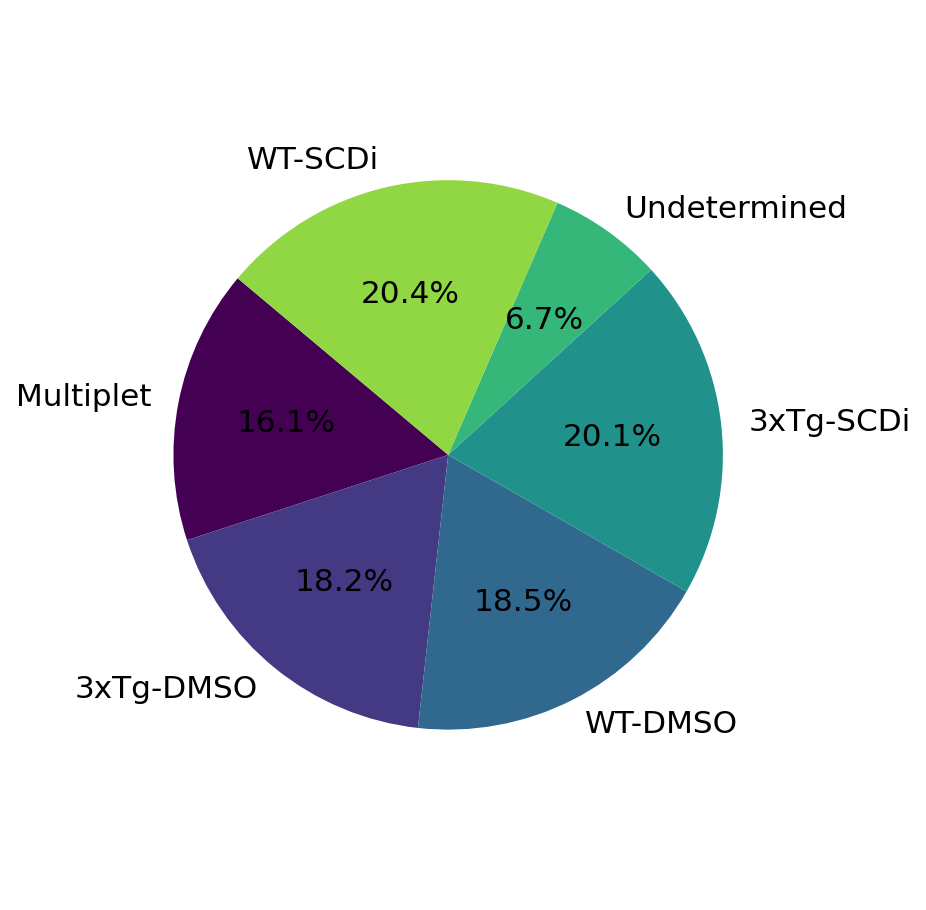

In [6]:
pie_chart_condition(adata.obs['Sample_Tag'].values, save_path='figures/pc_condition.png')

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

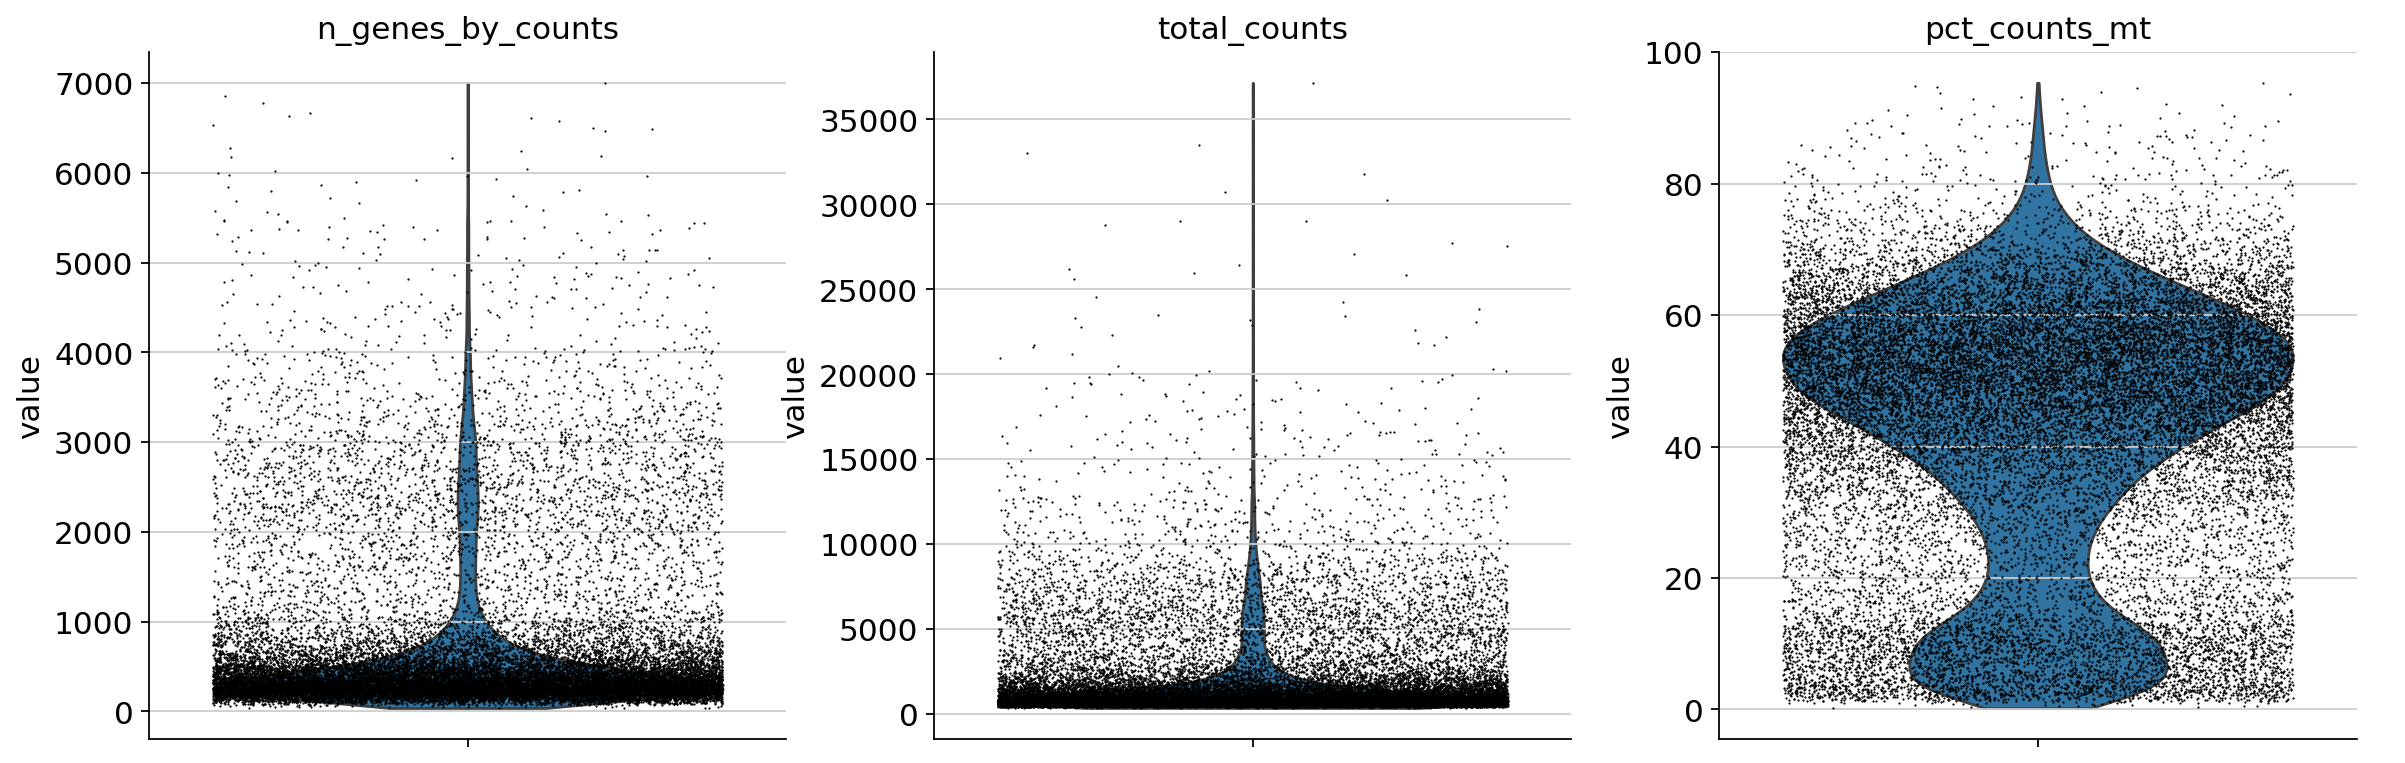

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

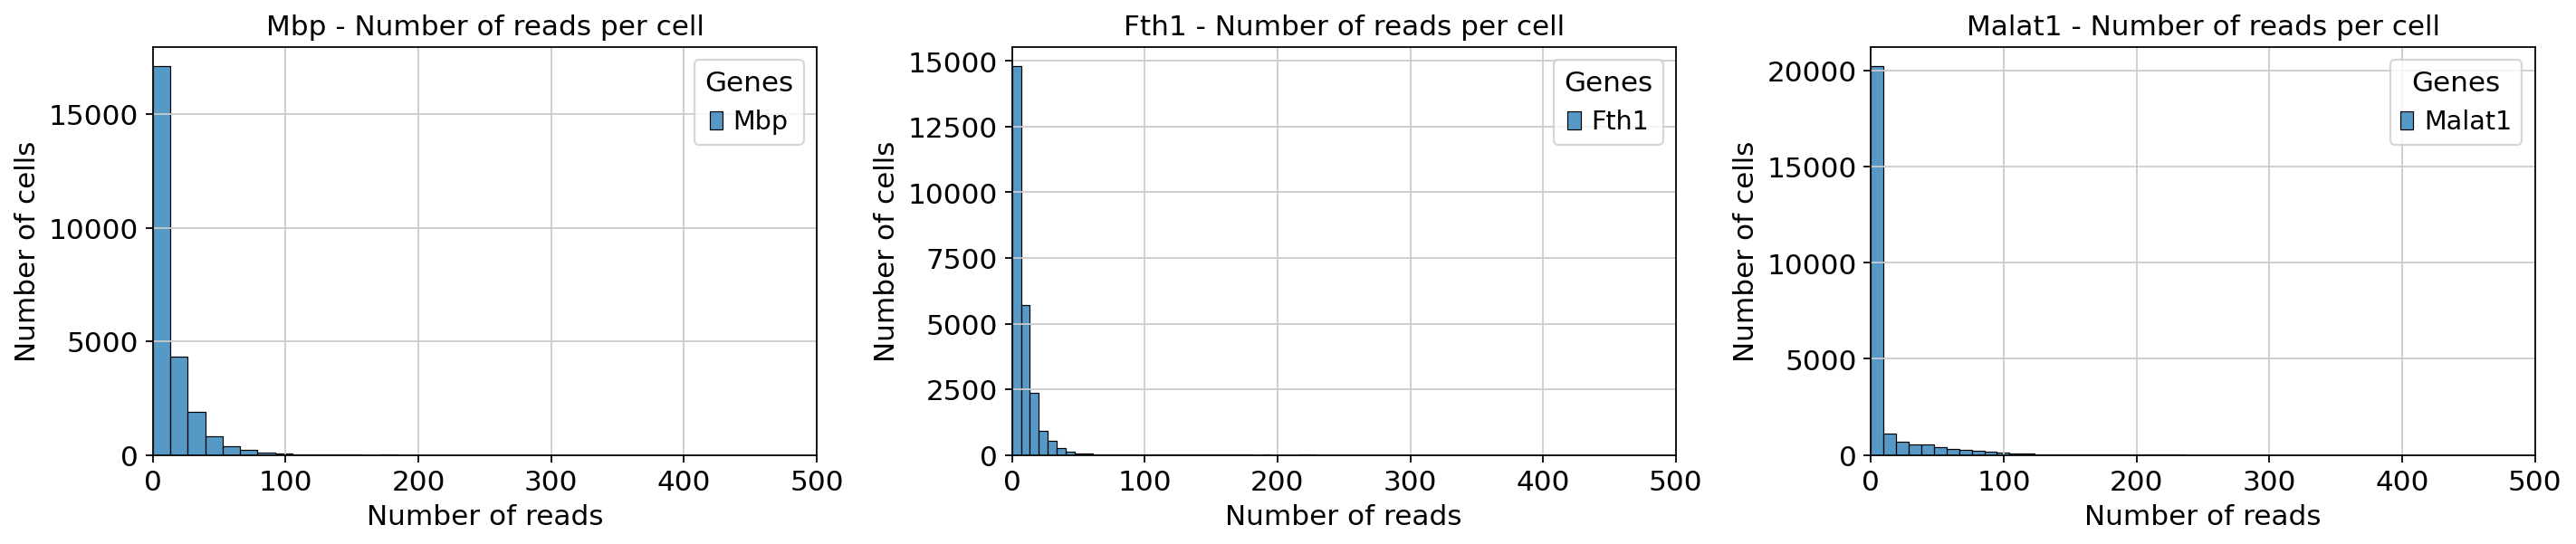

In [9]:
plot_top_n_distr(adata, top_n=3, save_path='figures/top_n_distr.png')

/home/client/projects/sc_alz/modules/visualize.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


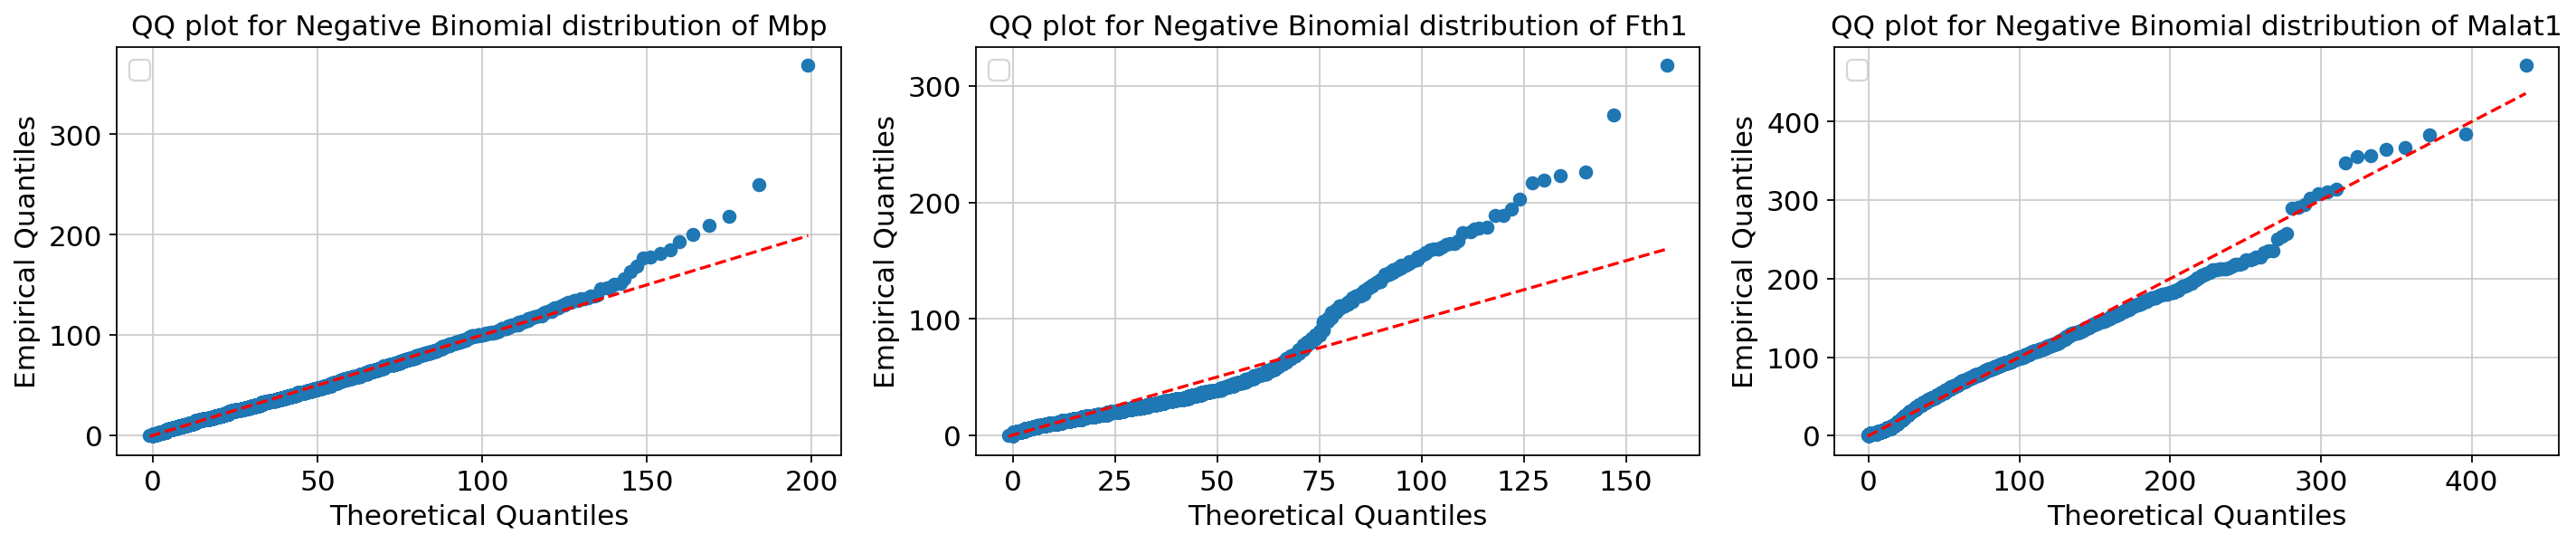

In [10]:
plot_top_genes_qq(adata, top_n=3, save_path='figures/top_n_qq.png')

# Quality control

In [11]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [12]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

In [13]:
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_4524/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


# Normalization

### Shifted logarithm

In [14]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

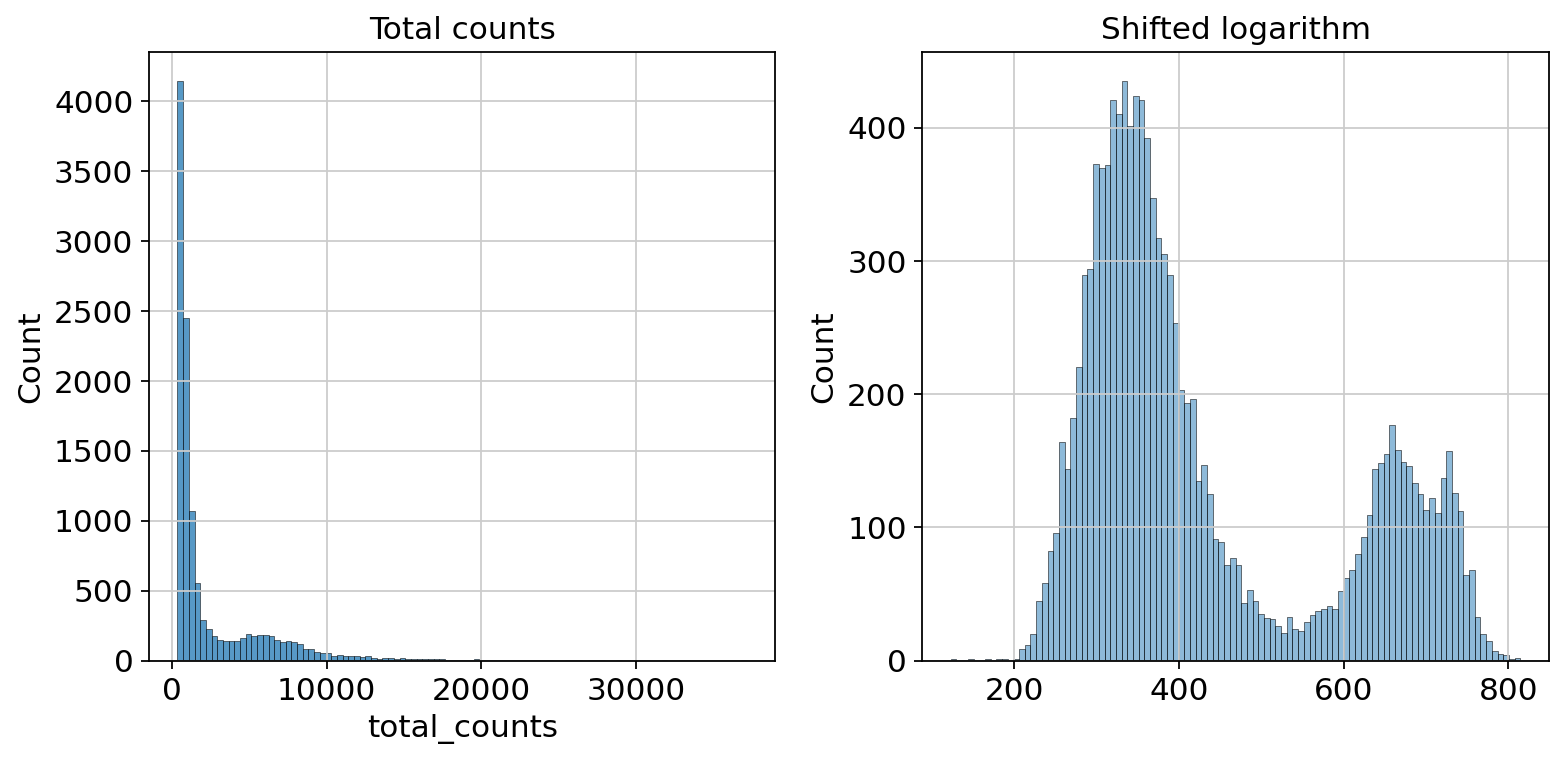

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
axes[1].legend_.remove()
plt.tight_layout()
plt.savefig('figures/shifted_log_distr.png', bbox_inches='tight')
plt.show()

### Scran normalization

In [ ]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

data_mat = adata_pp.X.T

if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

data_mat_dense = data_mat.toarray()
ro.globalenv["data_mat"] = pandas2ri.py2rpy(pd.DataFrame(data_mat_dense))
ro.globalenv["input_groups"] = pandas2ri.py2rpy(adata_pp.obs["groups"])

ro.r('''
size_factors <- sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts = as.matrix(data_mat))), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)
''')

size_factors = ro.globalenv["size_factors"]

adata.obs["size_factors"] = size_factors

scran_normalized = adata.X / adata.obs["size_factors"].values[:, None]

adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran_normalized))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
sns.histplot(adata.layers["scran_normalization"].sum(1).A1, bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p with Scran estimated size factors")
plt.tight_layout()
plt.savefig('figures/scran_distr.png', bbox_inches='tight')
plt.show()

### Pearson residuals

In [ ]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

residuals_sparse = adata.layers["analytic_pearson_residuals"]
if np.any(np.isnan(residuals_sparse.data)):
    print("Warning: NaNs found in the analytic Pearson residuals.")
    residuals_sparse.data = np.nan_to_num(residuals_sparse.data)

residuals_sum = residuals_sparse.sum(axis=1).A1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
sns.histplot(residuals_sum, bins=100, kde=False, ax=axes[1])
axes[1].set_title("Analytic Pearson residuals")
plt.tight_layout()
plt.savefig('figures/pearson_distr.png', bbox_inches='tight')
plt.show()

# Save adata object

In [16]:
adata.write("data/fede_count_normalized.h5ad")

In [17]:
adata = sc.read(
    filename="data/fede_count_normalized.h5ad"
)

# Select features

In [18]:
adata.X = adata.X.astype(np.float64)

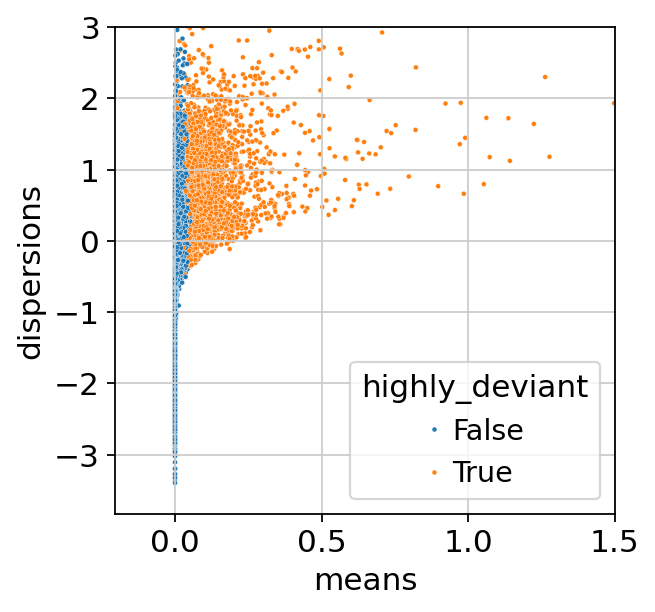

In [19]:
for layer in adata.layers:
    adata.layers[layer] = adata.layers[layer].astype('float64')
with localconverter(default_converter + anndata2ri.converter + pandas2ri.converter + numpy2ri.converter):
    ro.globalenv['adata'] = anndata2ri.py2rpy(adata)
ro.r('sce <- as(adata, "SingleCellExperiment")')
ro.r('sce <- devianceFeatureSelection(sce, assay="X")')
binomial_deviance = np.array(ro.r('rowData(sce)$binomial_deviance')).T
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, layer='log1p_norm')
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.savefig('figures/scran_highly_deviant.png')
plt.show()

In [20]:
adata.var["highly_variable"] = adata.var["highly_deviant"]

# Dimensionality reduction

### Principal component analysis (PCA)

In [21]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100, use_highly_variable=True, layer='log1p_norm')
pca_variance_ratio = adata.uns['pca']['variance_ratio']
print(np.sum(pca_variance_ratio[:10]))
print(np.sum(pca_variance_ratio[:20]))
print(np.sum(pca_variance_ratio[:50]))
print(np.sum(pca_variance_ratio[:100]))

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


0.224844483211716
0.251046928016038
0.29715069733017196
0.34809112946667414


In [ ]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100, use_highly_variable=True, layer='scran_normalization')
pca_variance_ratio = adata.uns['pca']['variance_ratio']
print(np.sum(pca_variance_ratio[:10]))
print(np.sum(pca_variance_ratio[:20]))
print(np.sum(pca_variance_ratio[:50]))
print(np.sum(pca_variance_ratio[:100]))

In [ ]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100, use_highly_variable=True, layer='analytic_pearson_residuals')
pca_variance_ratio = adata.uns['pca']['variance_ratio']
print(np.sum(pca_variance_ratio[:10]))
print(np.sum(pca_variance_ratio[:20]))
print(np.sum(pca_variance_ratio[:50]))
print(np.sum(pca_variance_ratio[:100]))

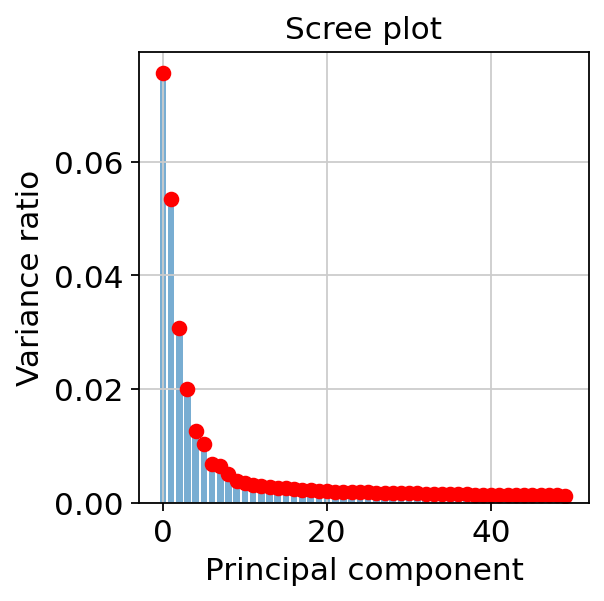

In [22]:
scree_plot(adata, layer='log1p_norm', save_path='figures/scree_plot.png')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


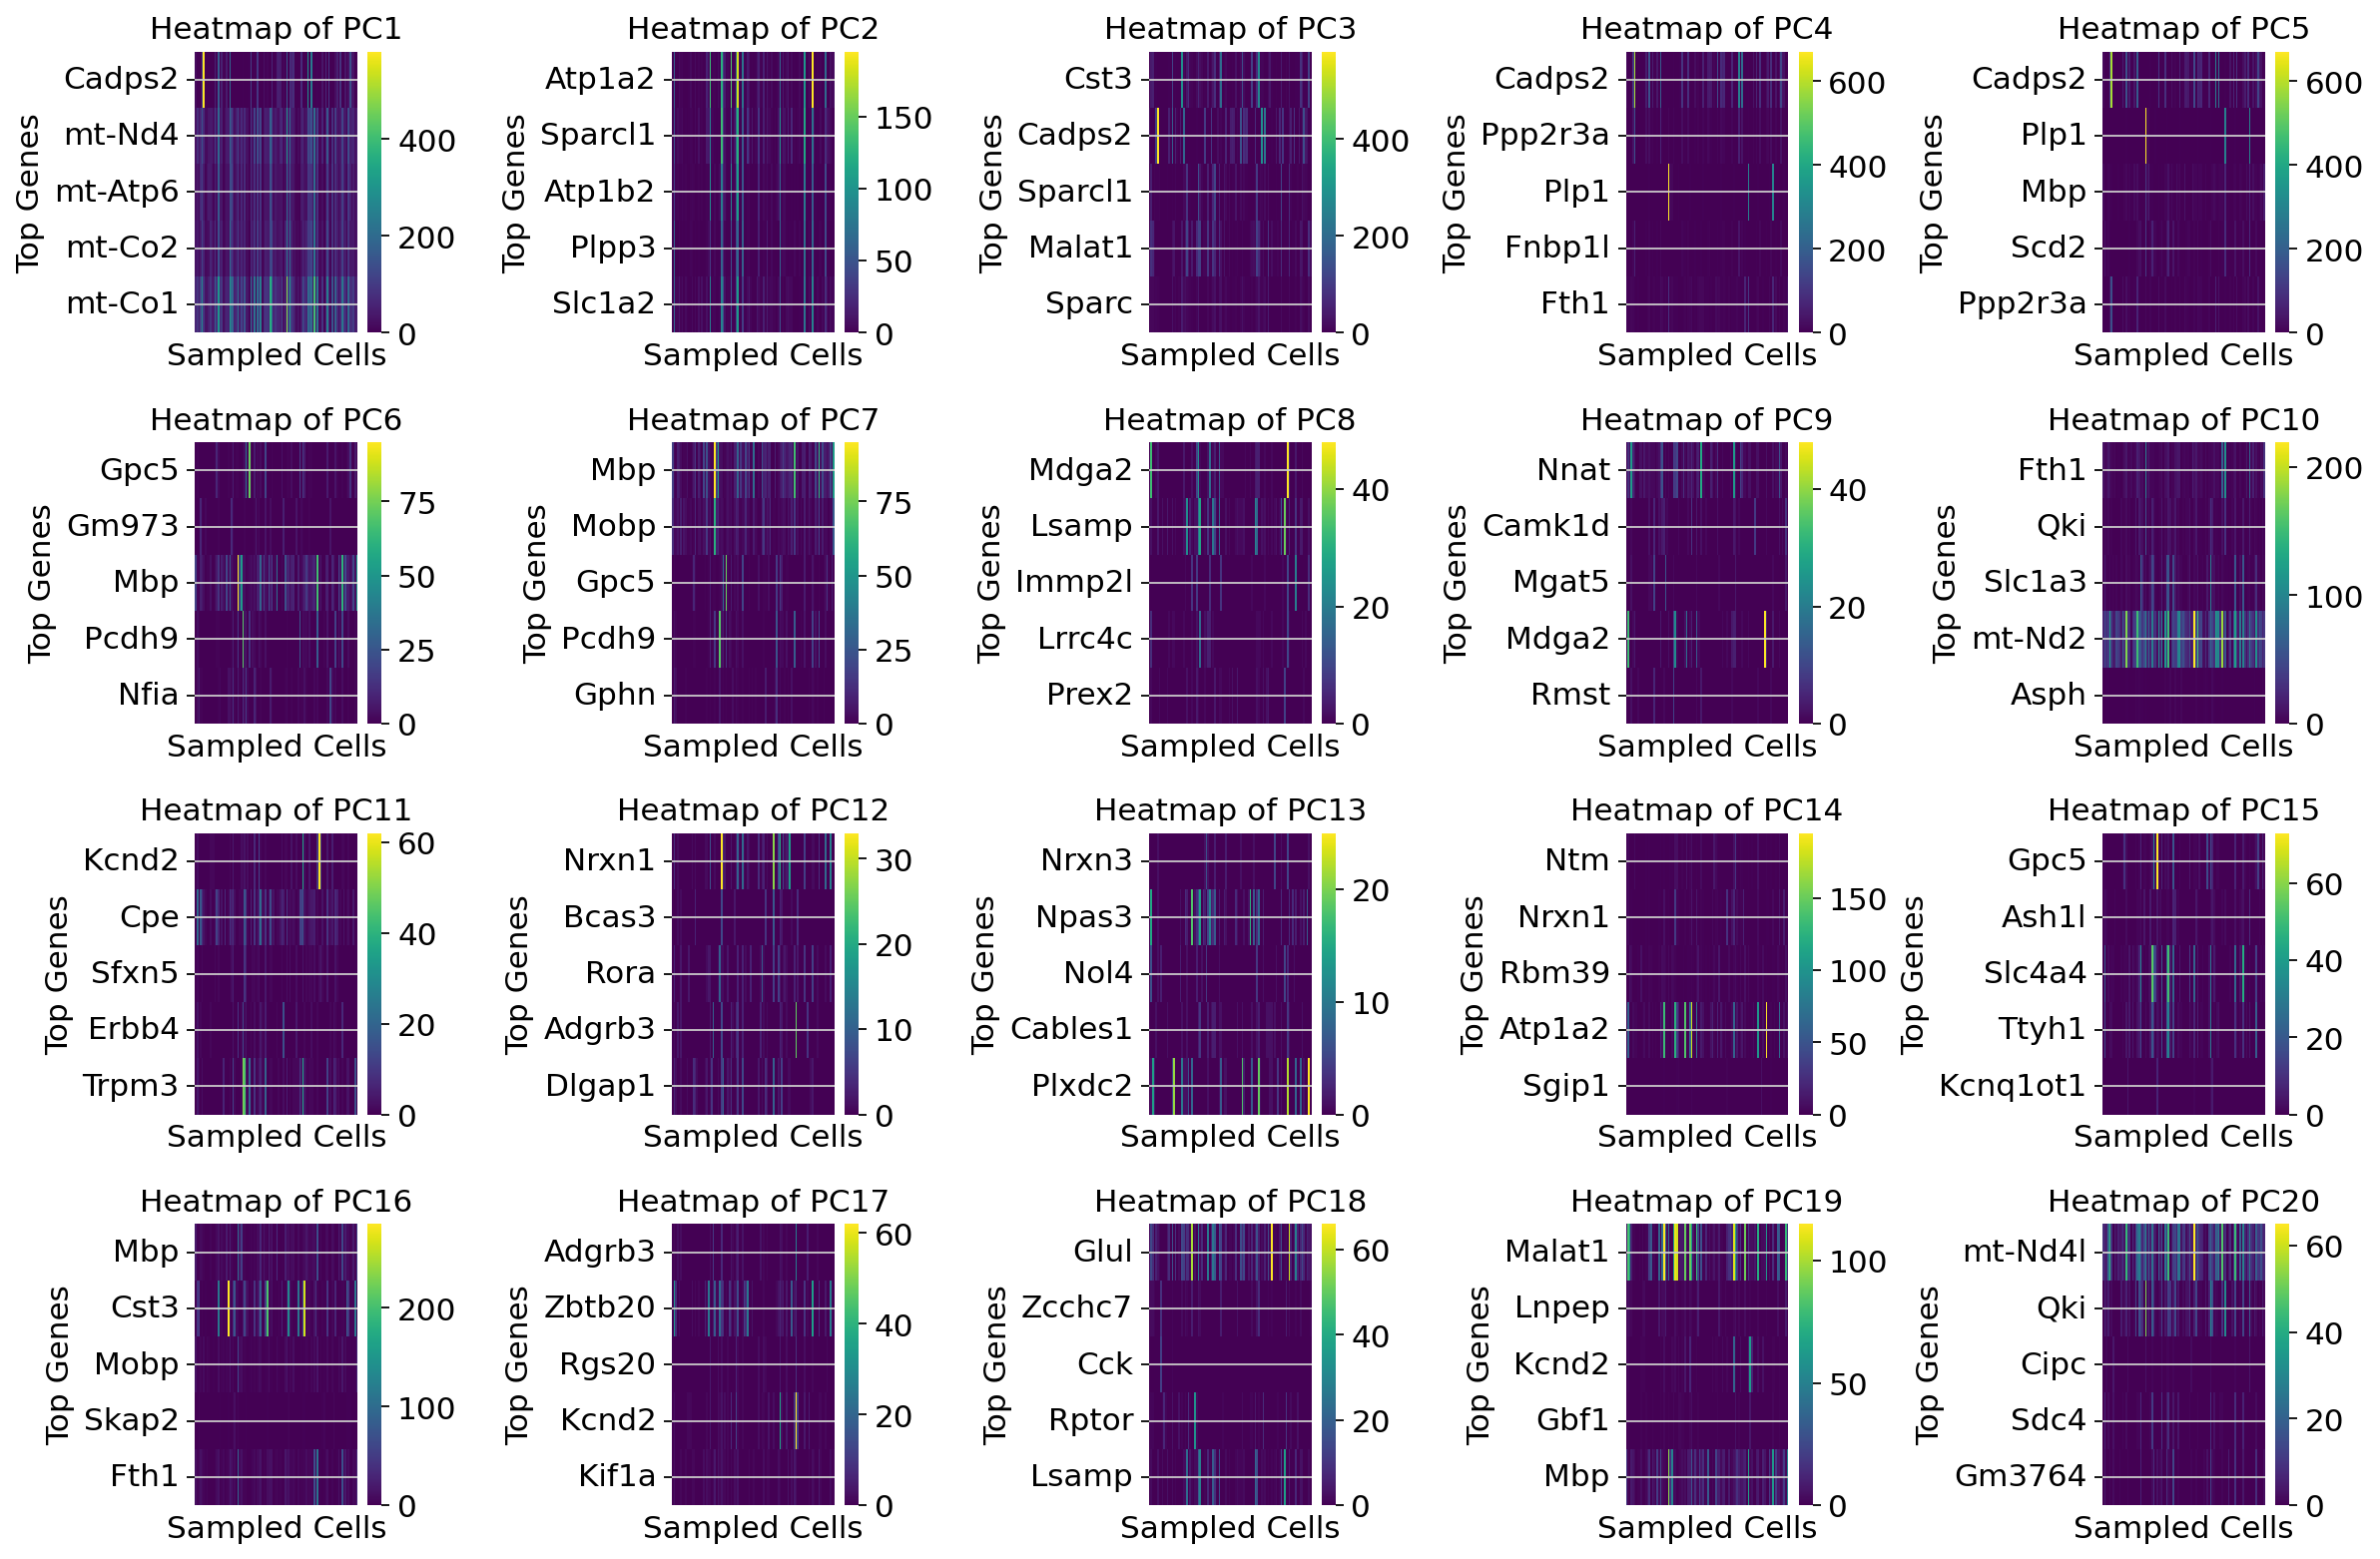

In [23]:
plot_top_genes_pca_heatmaps(adata, layer='log1p_norm', n_cells=100, n_top_genes=5, pc_index='20m', n_comps=50, random_seed=42, save_path='figures/pca_gene_heatmap.png')

In [24]:
sc.tl.pca(adata, n_comps=10, use_highly_variable=True, layer='log1p_norm')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


### Multi-class multi-label (MCML)

In [ ]:
subclass_name = adata.obs['subclass_name'].values.tolist()
sample_tag = adata.obs['Sample_Tag'].values.tolist()

In [ ]:
mcml = MCML(n_latent = 50, epochs = 100)
latentMCML = mcml.trainTest(adata.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname='figures/mcml_test.png')

In [ ]:
mcml = MCML(n_latent = 50, epochs = 20)
latentMCML = mcml.fit(adata.layers['log1p_norm'].toarray(), np.array([subclass_name]), fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname='figures/mcml_train.png')

In [ ]:
adata.obsm['X_mcml'] = latentMCML
mcml_latents = adata.obsm['X_mcml']

# scVI

In [ ]:
adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="Sample_Tag")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((20000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

# Batch correction

In [25]:
# harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
# adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Clustering

In [27]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.leiden(adata, resolution=0.5)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/tmp/ipykernel_4524/1784158519.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


In [28]:
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name', 'supertype_name'])

# Visualization

In [29]:
sc.tl.umap(adata)

### Leiden cluster visualization

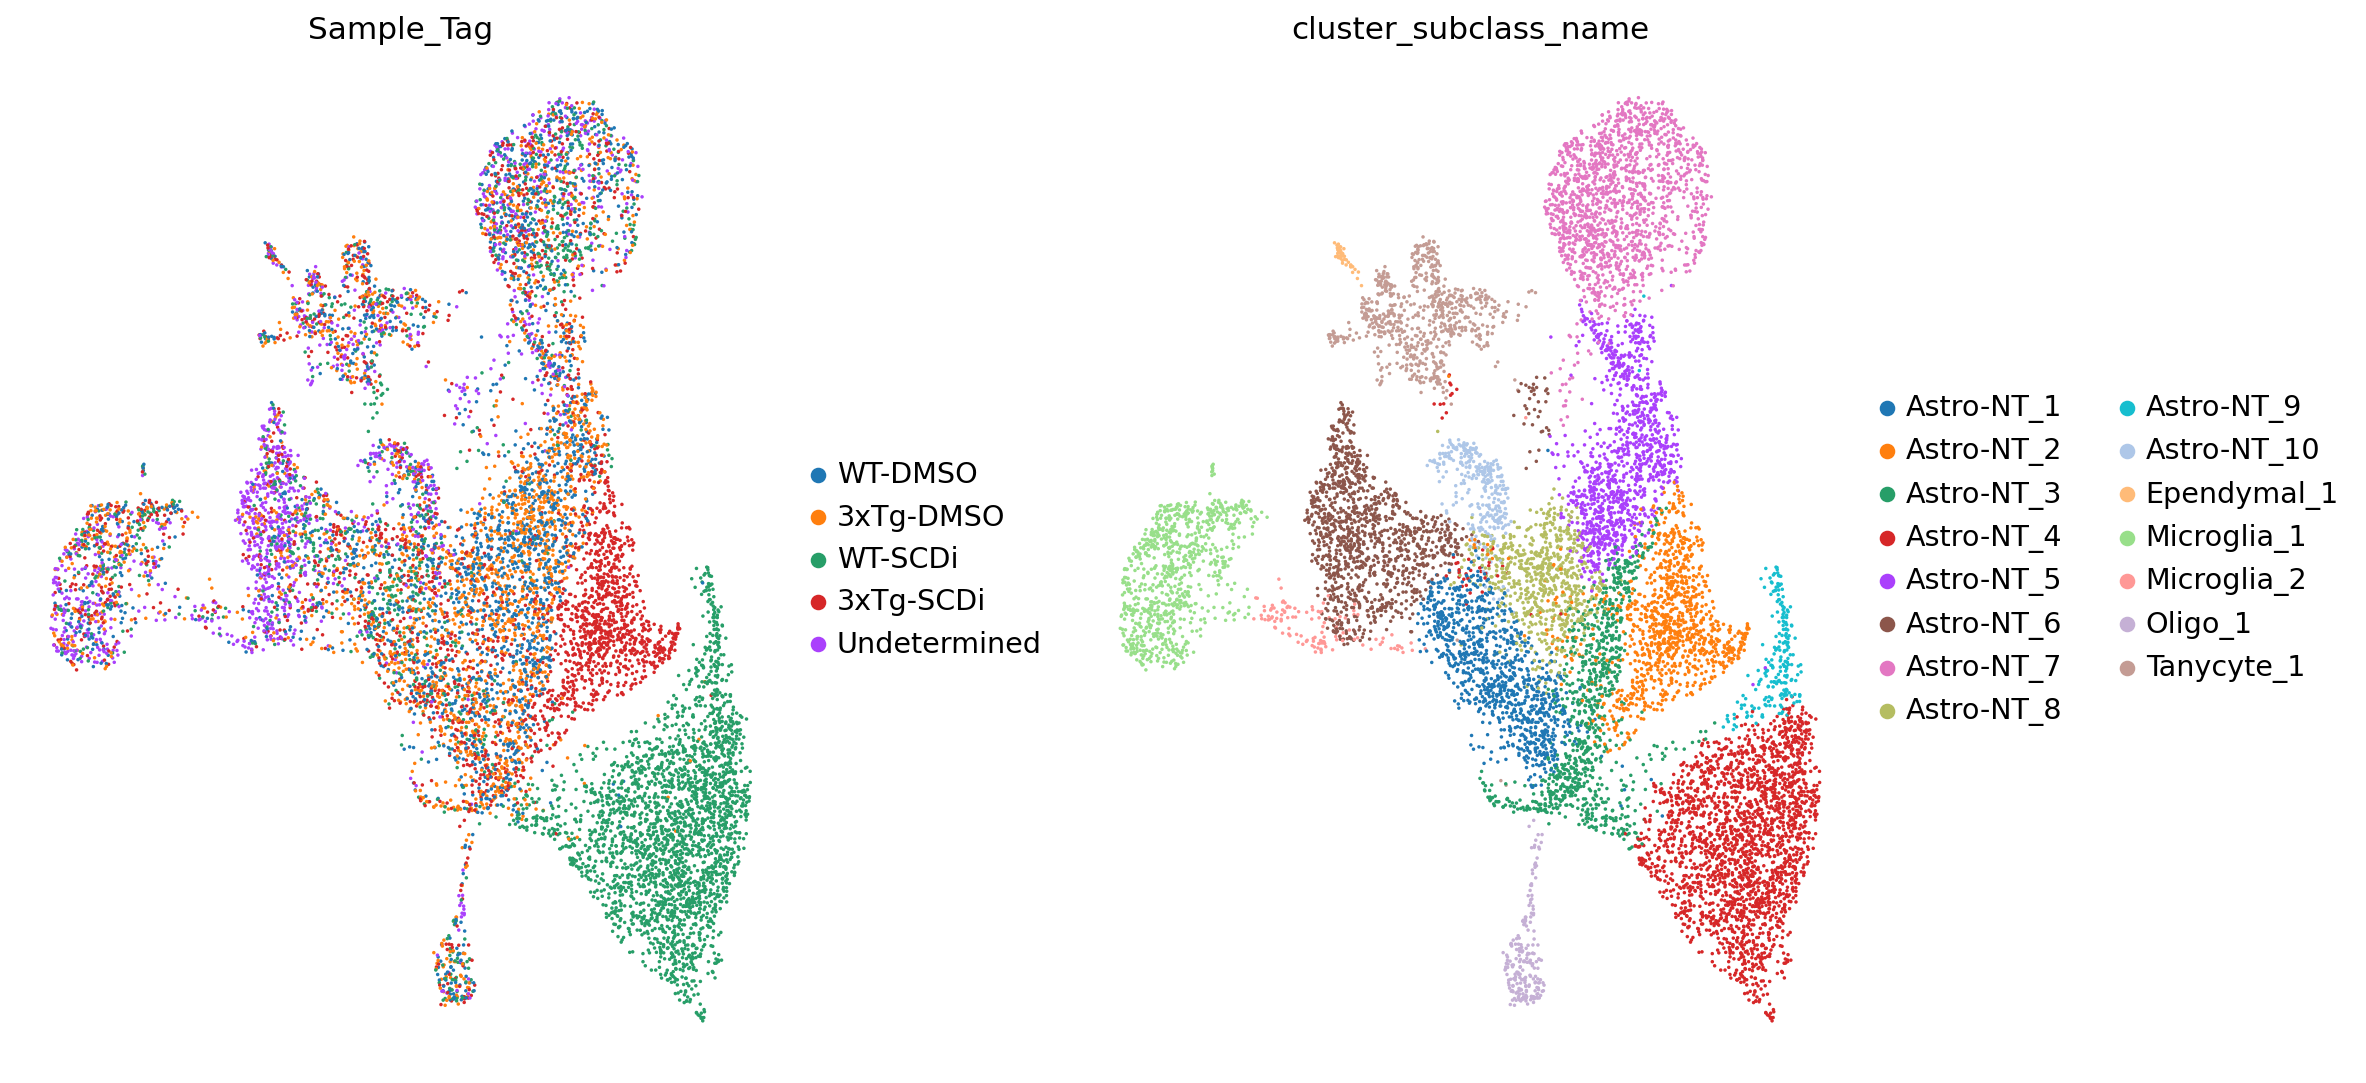

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.umap(adata, color='Sample_Tag', ax=axs[0], show=False)
sc.pl.umap(adata, color='cluster_subclass_name', ax=axs[1], show=False)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.savefig('figures/umap_leiden.png', bbox_inches='tight')
plt.show()

### Cell type visualization by experimental group

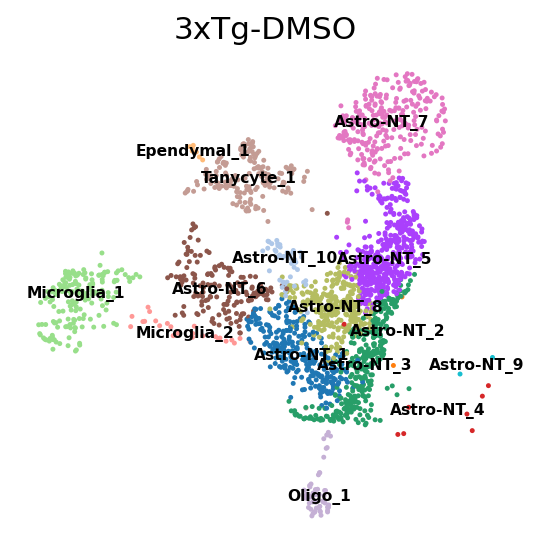

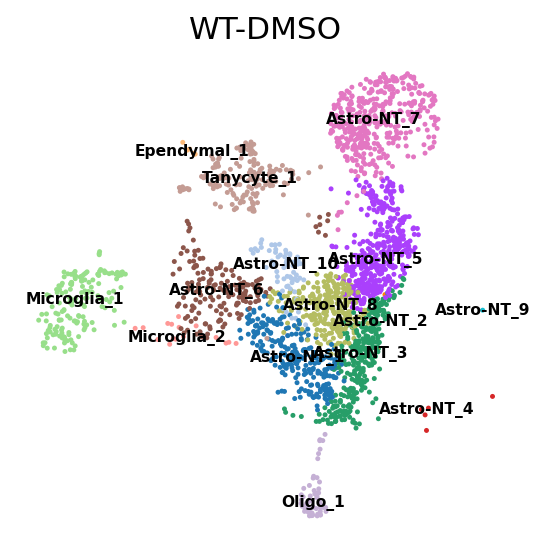

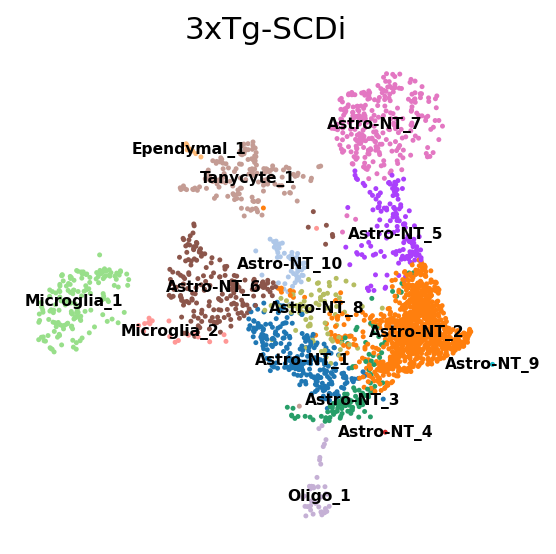

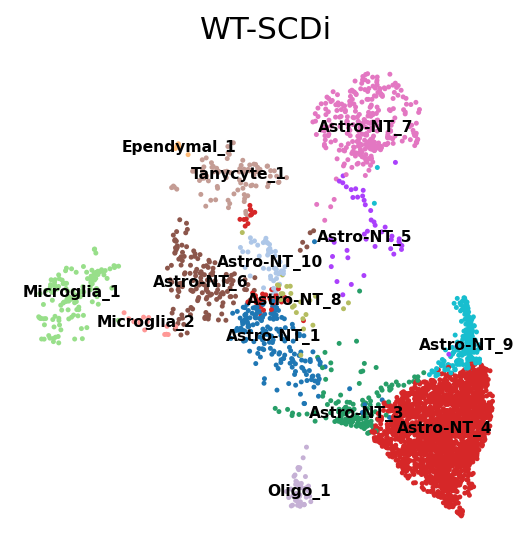

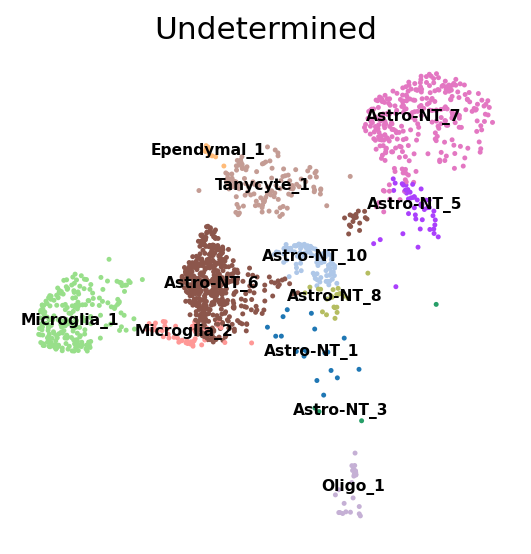

In [31]:
plot_umap(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Cluster homogeneity analysis

In [32]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

/home/client/projects/sc_alz/modules/visualize.py:344: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


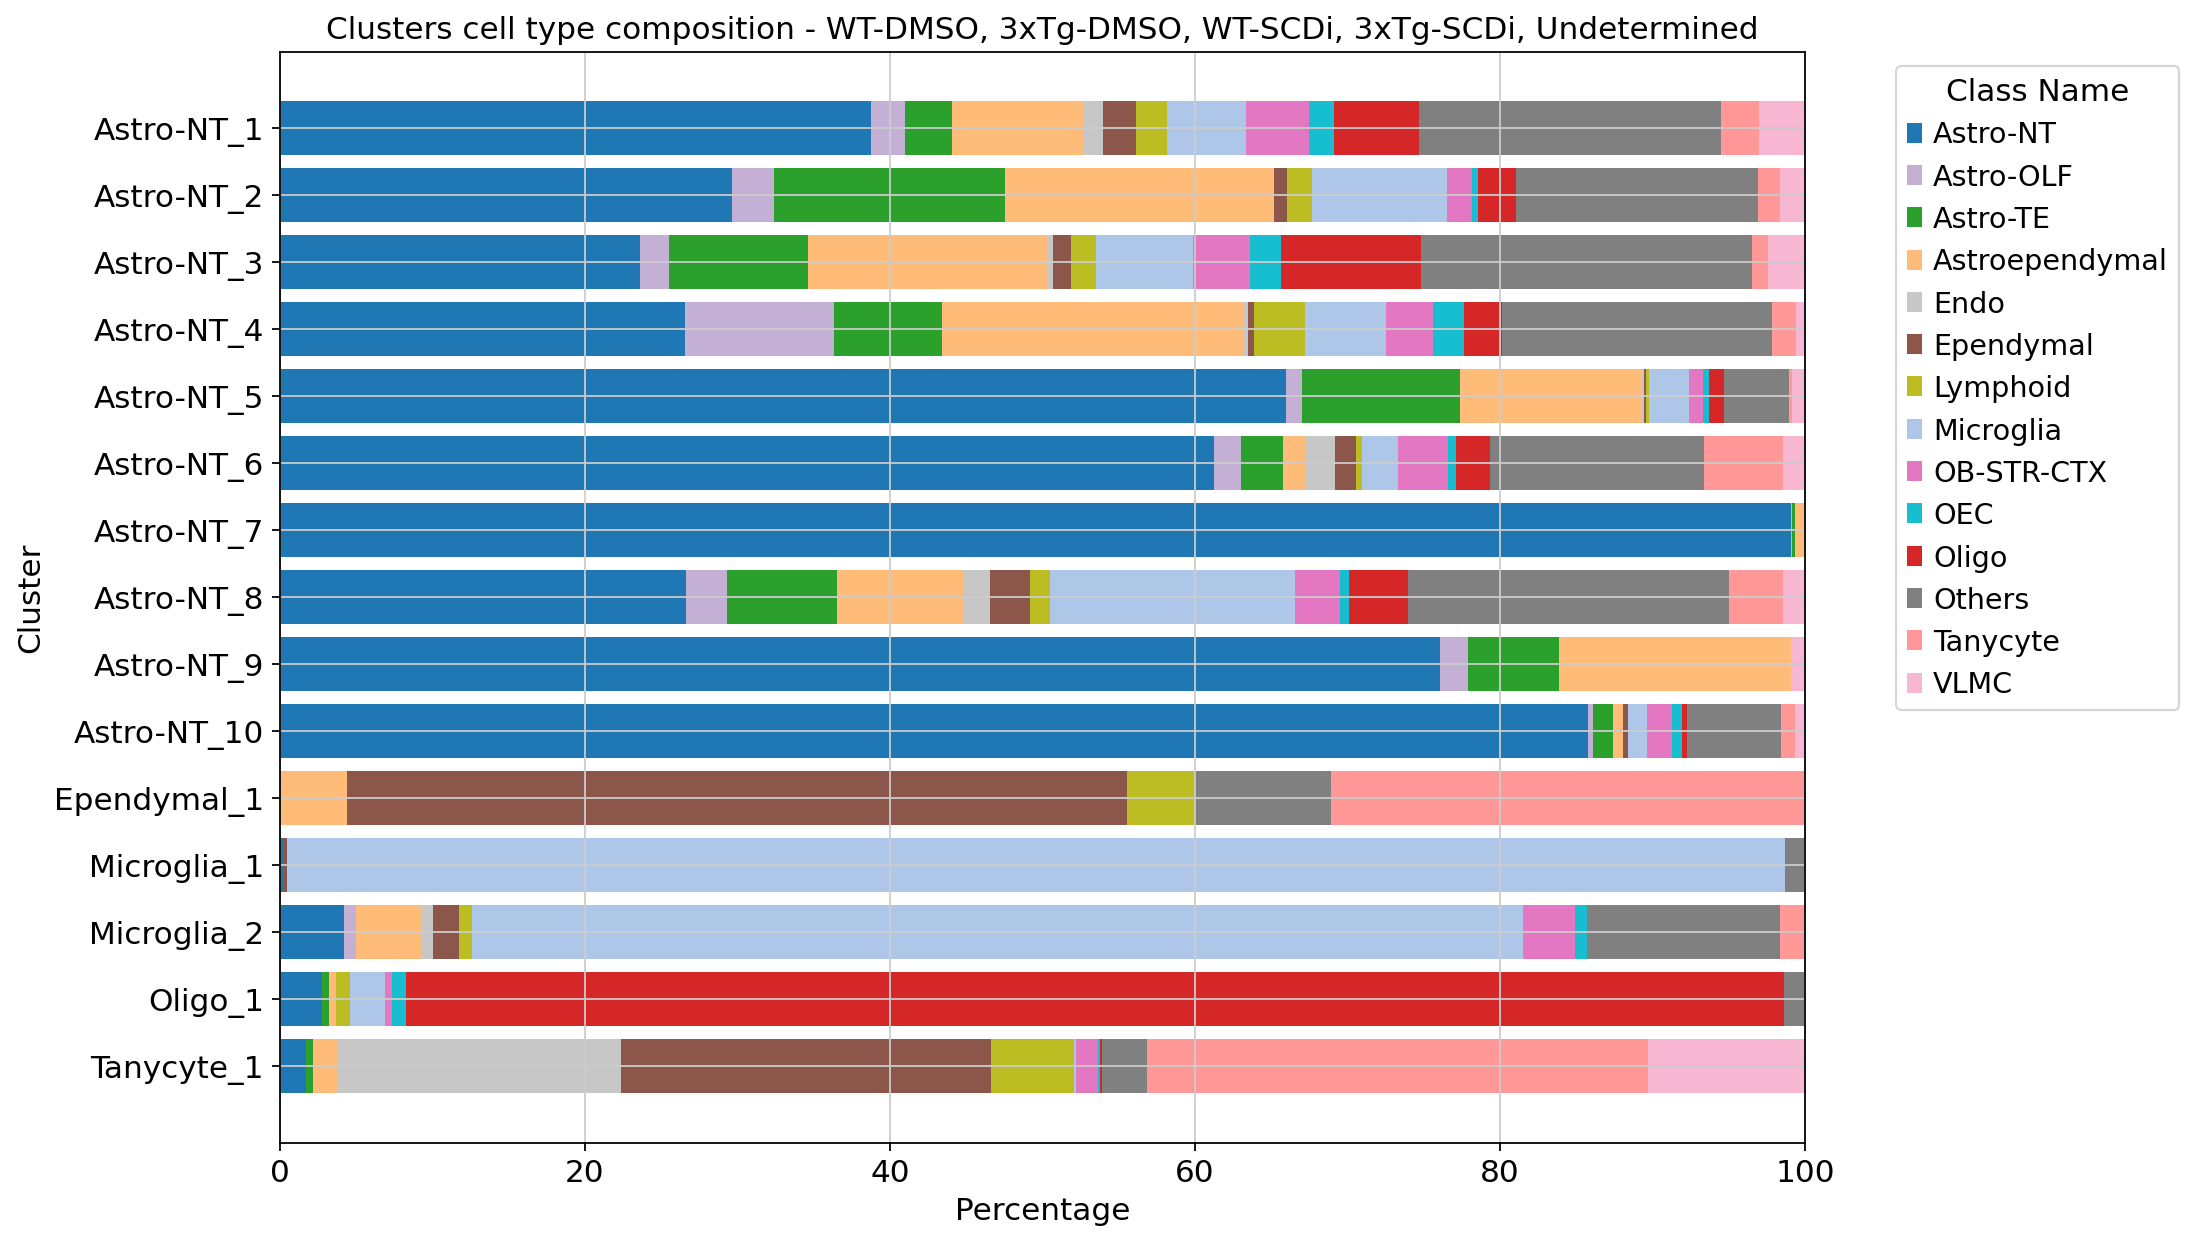

In [33]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/all_ditto.png')

# Dump data

In [34]:
adata.write("data/fede_count_clustered.h5ad")